In [ ]:
!pip install hazm

In [40]:
import pickle
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hazm import word_tokenize, Lemmatizer, Stemmer, Normalizer
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [ ]:
pd.set_option('display.max_colwidth', None) # optional

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# df = pd.read_csv('drive/MyDrive/Colab Notebooks/hamshahri_dataset.csv', index_col=0)

Mounted at /content/drive


In [ ]:
!cat Hamshahri-Corpus.txt | head -n100

In [4]:
# df.to_pickle("drive/MyDrive/Colab Notebooks/hamshahri_DataFrame.pkl")
df = pd.read_pickle("drive/MyDrive/Colab Notebooks/hamshahri_DataFrame.pkl")  

In [5]:
df

,category,category_id,tokens
0,adabh,0,"[جاودانگی, زندگی, گروهی, طریق, هنر, نگاه, نمای..."
1,adabh,0,"[رویداد, هنر, جهان, نمایشگاه, هنر, خدمت, دیکتا..."
2,adabh,0,"[بردیوار, نگارخانه, گالری, گلستان, نمایشگاه, ط..."
3,ejtem,1,"[بازی, جدی, گرفت#گیر, مطالعه, مقدمات, نقش, باز..."
4,elmfa,2,"[تخته, سیاه, غبار, سترده, شد#شو, اشاره;, رغم, ..."
...,...,...,...
165220,vrzsh,10,"[نماینده, فدراسیون, جهانی, والیبال, ایران, نظر..."
165221,vrzsh,10,"[شکست, نامدار, تکواندودر, پیکار, برتر, لیگ, گر..."
165222,vrzsh,10,"[ورزشگاه, بزرگ, دانشگاه, آزاد, تهران, ساخت#ساز..."
165223,vrzsh,10,"[رئیس, فدراسیون, پزشک, انتخاب, گروه, ورزش, مجم..."


In [6]:
LIMIT_CAT_COUNT_NEWS = 1000
cat_count = df.category.value_counts()
cat_count = cat_count[cat_count > LIMIT_CAT_COUNT_NEWS]
df = df[df['category'].isin(cat_count.keys())]
print(cat_count.shape)
# print(df_limited.shape)
print(df.shape)

(22,)
(148352, 3)


In [7]:
!wget -O hamshahri.rar "https://drive.google.com/u/0/uc?id=1D3yt99D0GcCRCbdKbUQGxbqjkeh91hTg&export=download&confirm=t&uuid=8cf8ef84-5033-4de3-97dc-588c35004d6c" 

--2022-07-12 06:37:06--  https://drive.google.com/u/0/uc?id=1D3yt99D0GcCRCbdKbUQGxbqjkeh91hTg&export=download&confirm=t&uuid=8cf8ef84-5033-4de3-97dc-588c35004d6c
Resolving drive.google.com (drive.google.com)... 142.250.141.101, 142.250.141.139, 142.250.141.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1D3yt99D0GcCRCbdKbUQGxbqjkeh91hTg&export=download&confirm=t&uuid=8cf8ef84-5033-4de3-97dc-588c35004d6c [following]
--2022-07-12 06:37:06--  https://drive.google.com/uc?id=1D3yt99D0GcCRCbdKbUQGxbqjkeh91hTg&export=download&confirm=t&uuid=8cf8ef84-5033-4de3-97dc-588c35004d6c
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-c8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/he2kr5d0ndi54t003u25uee8e8of6jkl/1657607775000/07941729757921727235/*/1D3yt99

In [8]:
!unrar x hamshahri.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from hamshahri.rar

Creating    hamshahriold                                              OK
Creating    hamshahriold/CLEF                                         OK
Creating    hamshahriold/CLEF/images                                  OK
Extracting  hamshahriold/CLEF/images/ar.JPG                                0%  OK 
Extracting  hamshahriold/CLEF/images/ar.psd                                0%  OK 
Extracting  hamshahriold/CLEF/images/ar2.JPG                               0%  OK 
Extracting  hamshahriold/CLEF/images/arrow.jpg                             0%  OK 
Extracting  hamshahriold/CLEF/images/basebg1.jpg                           0%  OK 
Extracting  hamshahriold/CLEF/images/basebg2.jpg                           0%  OK 
Extracting  hamshahriold/CLEF/images/celct_name.gif                        0%  OK 
Extracting  hamshahriold/CLEF/images/

In [9]:
!unzip hamshahriold/Corpus/Hamshahri-All\ \(SQL\).zip
!unzip hamshahriold/Corpus/Hamshahri-Corpus.zip
!unzip hamshahriold/Corpus/PersianStopWords.zip

Archive:  hamshahriold/Corpus/Hamshahri-All (SQL).zip
   creating: Hamshahri-All (SQL)/
  inflating: Hamshahri-All (SQL)/Hamshahri-Term_Data.MDF  
  inflating: Hamshahri-All (SQL)/Hamshahri-Term_Log.LDF  
Archive:  hamshahriold/Corpus/Hamshahri-Corpus.zip
  inflating: Hamshahri-Corpus.txt    
Archive:  hamshahriold/Corpus/PersianStopWords.zip
  inflating: PersianStopWords.txt    


In [ ]:
# !unzip hamshahriold/Corpus/Hamshahri-Query_Judgement.zip
# !unzip hamshahriold/Corpus/Hamshahri-Query_Judgement_old.zip


In [ ]:
!cat hamshahriold/Corpus/Hamshahri-Sample.txt

﻿.DID	1S1
.Date	75\04\02
.Cat	adabh
جاودانگي در زندگي گروهي از طريق هنر 
نگاهي به نمايشگاه آثار هنري احمد طباطبايي 
موضوع آثار طباطبايي مورچگان هستند ولي در باطن چنين ظاهري، اين 
انسانهاهستند كه در هيبتي حشره گونه در تابلوهاي نقاشي نمايشگر 
گوشه هايي از زندگي خود هستند. 

.DID	2S1
.Date	75\05\02
.Cat	adabh
رويدادهاي هنري جهان 
نمايشگاه هنر در خدمت ديكتاتورها 
نمايشگاه ارتباط بين هنر وقدرت ديكتاتورها در اروپا درشهر برلين 
آغاز به كار كرد. به گزارش واحد مركزي خبر به نقل از شبكه خبري 

.DID	3S1
.Date	75\04\12
.Cat	adabh
برديوار نگارخانه ها 
گالري گلستان: 
نمايشگاه طرح و ساخت نقره وسنگ ثريا امانپور از 5 تيرماه 12تا
از ساعت 9 تا 12 16تا 20 و خيابان دروس شهيدكماسايي شماره 
. تلفن 2541589. 42 
نگارخانه آفرينش سرو: نمايشگاه آثار عكاسي شهريار توكلي و فرشيد 

.DID	4S1
.Date	75\04\02
.Cat	ejtem
بازي را جدي بگيريم 
مطالعه اي مقدماتي پيرامون نقش بازي در زندگي اجتماعي و ساماندهي 
گردشگاهها 
حركت و شلوغ كردن جلوه اي ازلذت كودكانه است، سركوبومخالفت با 
جنب وجوش كودكان بتدريج آسيب رواني به بار مي آورد 

In [ ]:
dict_ = {}
list_of_dict = []

with open('Hamshahri-Corpus.txt',"r") as content:
    content = content.read()
lines = content.split("\n")
lines = [line for line in lines if line]
line_count = len(lines) -1 
  
for index, line in enumerate(lines):
    if '.DID' in line and dict_:
        list_of_dict.append(dict_)
        dict_ = {}

    if '.Cat' in line:
        dict_['category'] = line.split(".Cat\t",1)[1]

    elif not re.match(r"^.[A-Z]", line) and line:
        if 'text' in dict_:
            dict_['text'] += line
        else:
            dict_['text'] = line

    if line_count == index and dict_:
        list_of_dict.append(dict_)
        dict_ = {}

len(list_of_dict)

In [ ]:
df = pd.DataFrame(list_of_dict)
df.head(20)
df.to_csv('data.csv')

In [ ]:
df['category_id'] = df['category'].factorize()[0]
df.tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,category,category_id,tokens
165207,siasi,9,"[هفتم, هشتم, اسفند, برگزار, شد#شو, نشست, ماهان..."
165208,siasi,9,"[رئیس, جمهوری, جمع, فرمانده, حفاظت, انصارالمهد..."
165209,siasi,9,"[روزنامه, انگلیسی, گاردین, آمریکایی, ناچارند, ..."
165210,siasi,9,"[خبر, کوتاه, دبیرخانه, مجلس, خبرگان, رهبر, جام..."
165219,vrzsh,10,"[گره, کور, کشتی, شودگروه, ورزش, حضور, رسم, محم..."
165220,vrzsh,10,"[نماینده, فدراسیون, جهانی, والیبال, ایران, نظر..."
165221,vrzsh,10,"[شکست, نامدار, تکواندودر, پیکار, برتر, لیگ, گر..."
165222,vrzsh,10,"[ورزشگاه, بزرگ, دانشگاه, آزاد, تهران, ساخت#ساز..."
165223,vrzsh,10,"[رئیس, فدراسیون, پزشک, انتخاب, گروه, ورزش, مجم..."
165224,vrzsh,10,"[نتایج, هفته, یازدهم, وزنه, بردار, باشگاه, گرو..."


In [ ]:
df.isna().sum()

category       0
category_id    0
tokens         0
dtype: int64

In [ ]:
category = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category

,category,category_id
0,adabh,0
3,ejtem,1
4,elmfa,2
10,eqtes,3
21,gozar,4
22,havad,5
32,kharj,6
42,maqal,7
43,shahr,8
60,siasi,9


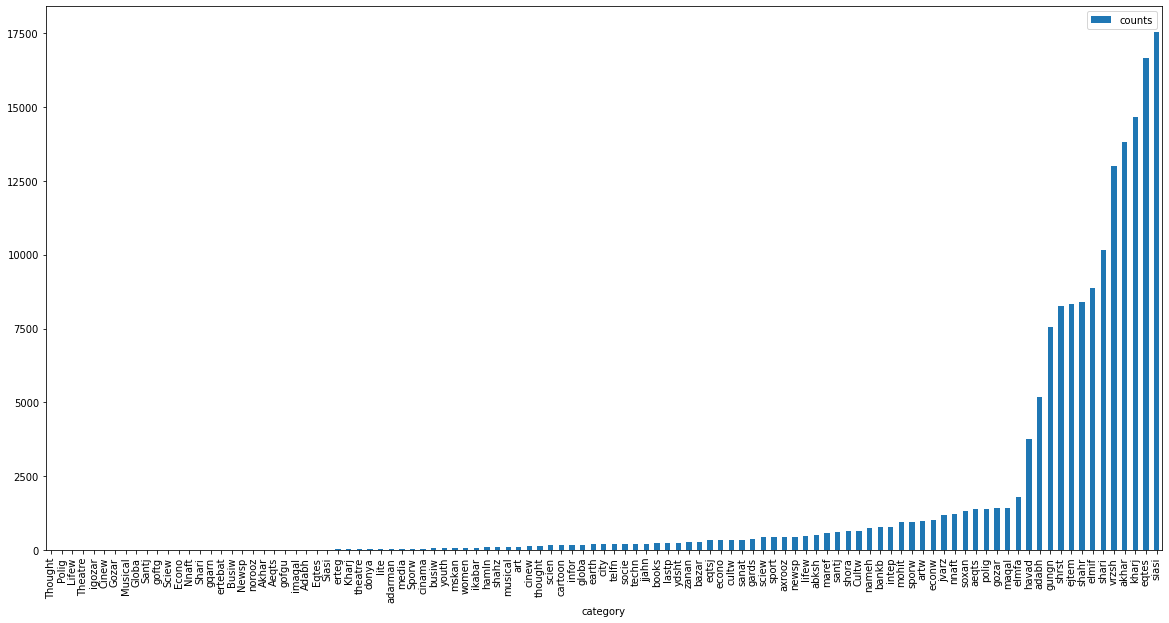

In [ ]:
df.groupby(['category']).size().reset_index(name='counts').sort_values(['counts'], ascending=True).plot(x ='category', y='counts', kind='bar', figsize=(20,10))
# df.groupby(['category']).size().reset_index(name='counts').sort_values(['counts'], ascending=False)[:50].plot(x ='category', y='counts', kind='bar', figsize=(20,10))

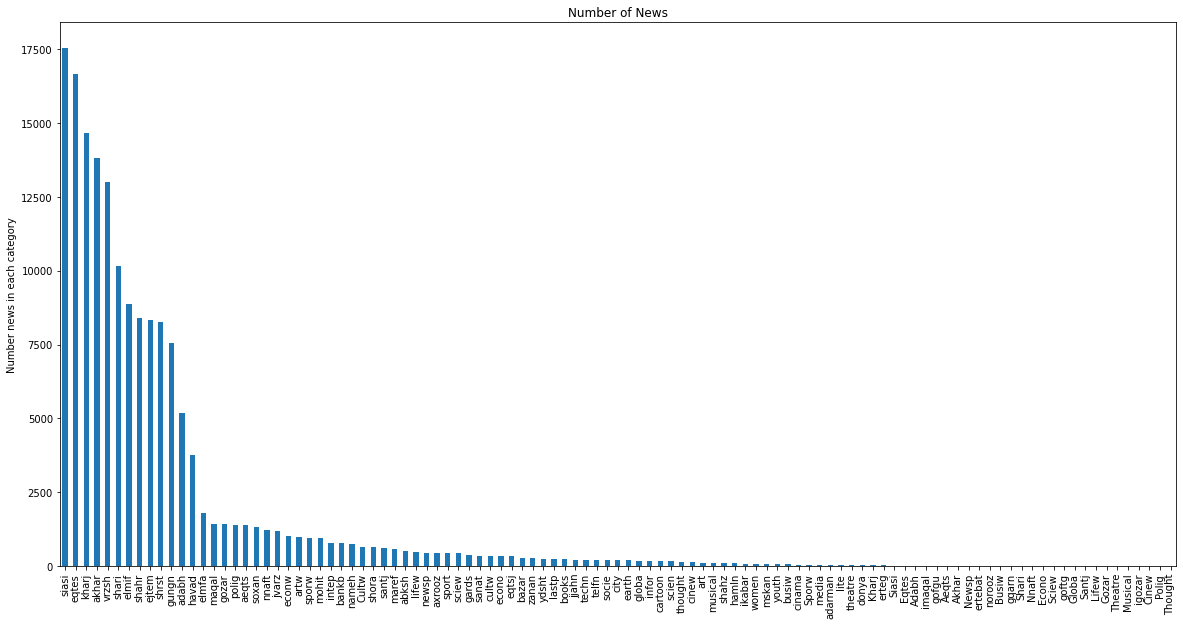

In [ ]:
df['category'].value_counts().sort_values(ascending=False).plot(kind='bar', title='Number of News', 
                                                                ylabel='Number news in each category', figsize=(20,10))

In [ ]:
df[df['category'] == 'sciew']

,category,category_id,tokens


In [ ]:
!cat Hamshahri-Corpus.txt | grep -B 5 -A 5 "روزنامه صبح ايران"

In [ ]:
!cat Hamshahri-Corpus.txt | grep ".Cat" | wc -l

165262


In [ ]:
!cat Hamshahri-Corpus.txt | grep ".DID" | wc -l

165233


In [32]:
def remove_persian_stopword(tokens):
    # return [word for word in tokens if not word in stop_words and word and word not in proned]
    return [word for word in tokens if not word in stop_words and word]

normalizer = Normalizer()


def normalize_text(text):
    return normalizer.normalize(text)

    
with open("PersianStopWords.txt", "r") as file:
    raw_stop_words = file.read()

stop_words = raw_stop_words.split("\n")
stop_words = [normalize_text(word) for word in stop_words]
# stop_words[:10]

lemmatizer = Lemmatizer()


def lemma_tokenizer(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]
    # return [lemmatizer.lemmatize(token).split("#")[0] for token in tokens]


stemmer = Stemmer()


def stem_tokenizer(tokens):
    return [stemmer.stem(token) for token in tokens]


def text_normalization(text):
    raw_text = re.sub(r"-+|\d+|\s+", " ", text)
    raw_text = normalize_text(raw_text)

    return raw_text

def tokenize_text(text, type="lemma"):
    tokens = word_tokenize(text)
    tokens = remove_persian_stopword(tokens)
    
    if type == "lemma":
        tokens = remove_persian_stopword(lemma_tokenizer(tokens))
    elif type == "stem":
        tokens = remove_persian_stopword(stem_tokenizer(tokens))

    return tokens


In [ ]:
df["normalized_sent"] = df["text"].apply(lambda x: text_normalization(x))
df.head()

In [ ]:
df["tokens"] = df["normalized_sent"].apply(lambda x: tokenize_text(x))
df.head()

In [ ]:
df.to_csv('H_data.csv')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !mv H_data.csv hamshahri_dataset.csv
# !cp hamshahri_dataset.csv drive/MyDrive/Colab\ Notebooks

# !sudo apt-get install rar
# !mkdir data_set_hamshahri && mv hamshahri_dataset.csv data_set_hamshahri/
# !rar a hamshahri_dataset.rar hamshahri_dataset.csv
# !cp hamshahri_dataset.rar drive/MyDrive/Colab\ Notebooks

Mounted at /content/drive


In [ ]:
df

,category,text,category_id,normalized_sent,tokens
0,adabh,جاودانگي در زندگي گروهي از طريق هنر نگاهي به ن...,0,جاودانگی در زندگی گروهی از طریق هنر نگاهی به ن...,"['جاودانگی', 'زندگی', 'گروهی', 'طریق', 'هنر', ..."
1,adabh,رويدادهاي هنري جهان نمايشگاه هنر در خدمت ديكتا...,0,رویدادهای هنری جهان نمایشگاه هنر در خدمت دیکتا...,"['رویداد', 'هنر', 'جهان', 'نمایشگاه', 'هنر', '..."
2,adabh,برديوار نگارخانه ها گالري گلستان: نمايشگاه طرح...,0,بردیوار نگارخانه‌ها گالری گلستان: نمایشگاه طرح...,"['بردیوار', 'نگارخانه', 'گالری', 'گلستان', 'نم..."
3,ejtem,بازي را جدي بگيريم مطالعه اي مقدماتي پيرامون ن...,1,بازی را جدی بگیریم مطالعه‌ای مقدماتی پیرامون ن...,"['بازی', 'جدی', 'گرفت#گیر', 'مطالعه', 'مقدمات'..."
4,elmfa,تخته سياه و غباري كه سترده نمي شود... اشاره; ب...,2,تخته سیاه و غباری که سترده نمی‌شود … اشاره; به...,"['تخته', 'سیاه', 'غبار', 'سترده', 'شد#شو', 'اش..."
...,...,...,...,...,...
165220,vrzsh,نماينده فدراسيون جهاني واليبال از ايران هر نظ...,10,نماینده فدراسیون جهانی والیبال از ایران هر نظر...,"['نماینده', 'فدراسیون', 'جهانی', 'والیبال', 'ا..."
165221,vrzsh,شكست نامداران تكواندودر پيكارهاي برتر ليگ گروه...,10,شکست نامداران تکواندودر پیکارهای برتر لیگ گروه...,"['شکست', 'نامدار', 'تکواندودر', 'پیکار', 'برتر..."
165222,vrzsh,ورزشگاه بزرگ دانشگاه آزاد در تهران ساخته مي شو...,10,ورزشگاه بزرگ دانشگاه آزاد در تهران ساخته می‌شو...,"['ورزشگاه', 'بزرگ', 'دانشگاه', 'آزاد', 'تهران'..."
165223,vrzsh,رئيس فدراسيون پزشكي انتخاب شد گروه ورزشي: مجمع...,10,رئیس فدراسیون پزشکی انتخاب شد گروه ورزشی: مجمع...,"['رئیس', 'فدراسیون', 'پزشک', 'انتخاب', 'گروه',..."


In [ ]:
df.drop(['text', 'normalized_sent'], axis=1, inplace=True)

In [ ]:
import ast
x = ast.literal_eval(df.loc[1, 'tokens'])
df["tokens"] = df["tokens"].apply(lambda x: ast.literal_eval(x))

token_df = df["tokens"]
tokens = token_df.explode().dropna().tolist()
print(len(tokens))
tokens[:10]

38677129


['جاودانگی',
 'زندگی',
 'گروهی',
 'طریق',
 'هنر',
 'نگاه',
 'نمایشگاه',
 'آثار',
 'هنر',
 'احمد']

In [ ]:
len(set(tokens))

453875

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


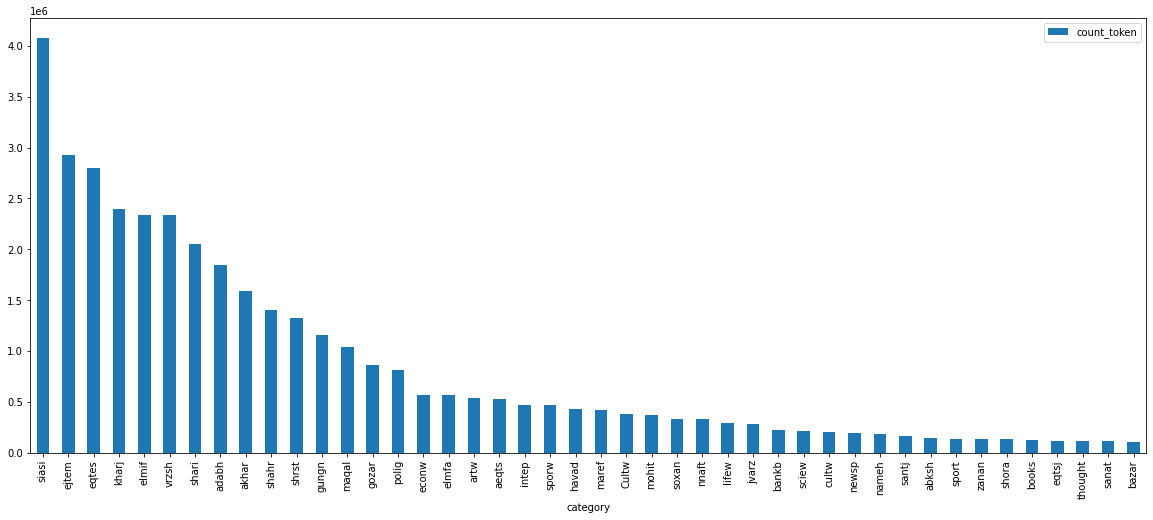

In [ ]:
ll = [0 for i in range(105)]
for index, row in df.iterrows():
    ll[row['category_id']] += len(row['tokens'])

category['count_token'] = ll
category.sort_values(by='count_token', ascending=False)[category['count_token'] > 0.1e6].plot(x='category', y='count_token',kind='bar', figsize=(20,8))

In [ ]:
# df.to_pickle("drive/MyDrive/Colab Notebooks/hamshahri_DataFrame.pkl")
df = pd.read_pickle("drive/MyDrive/Colab Notebooks/hamshahri_DataFrame.pkl")  

In [ ]:
df

,category,category_id,tokens
0,adabh,0,"[جاودانگی, زندگی, گروهی, طریق, هنر, نگاه, نمای..."
1,adabh,0,"[رویداد, هنر, جهان, نمایشگاه, هنر, خدمت, دیکتا..."
2,adabh,0,"[بردیوار, نگارخانه, گالری, گلستان, نمایشگاه, ط..."
3,ejtem,1,"[بازی, جدی, گرفت#گیر, مطالعه, مقدمات, نقش, باز..."
4,elmfa,2,"[تخته, سیاه, غبار, سترده, شد#شو, اشاره;, رغم, ..."
...,...,...,...
165220,vrzsh,10,"[نماینده, فدراسیون, جهانی, والیبال, ایران, نظر..."
165221,vrzsh,10,"[شکست, نامدار, تکواندودر, پیکار, برتر, لیگ, گر..."
165222,vrzsh,10,"[ورزشگاه, بزرگ, دانشگاه, آزاد, تهران, ساخت#ساز..."
165223,vrzsh,10,"[رئیس, فدراسیون, پزشک, انتخاب, گروه, ورزش, مجم..."


In [ ]:
type(df['tokens'].values)

numpy.ndarray

In [35]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 150
df_train = df

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='')
tokenizer.fit_on_texts(df_train['tokens'].values)
word_index = tokenizer.word_index

print(f"unique tokens: {len(word_index)}")

unique tokens: 392031


In [36]:
sorted_count_list = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)
sorted_count_list[:15]

[('کرد#کن', 566348),
 ('شد#شو', 395836),
 ('کشور', 253365),
 ('گفت#گو', 226652),
 ('ایران', 193418),
 ('سال', 179014),
 ('بود#باش', 178051),
 ('داشت#دار', 162458),
 ('داد#ده', 147899),
 ('گرفت#گیر', 140140),
 ('اسلام', 124784),
 ('تهران', 123048),
 ('شهر', 108528),
 ('روز', 100149),
 ('توانست#توان', 99354)]

In [ ]:
df_train['tokens'].values[0]

In [44]:
X = tokenizer.texts_to_sequences(df_train['tokens'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (148352, 300)


In [45]:
X

array([[ 2411,  1555,   242, ..., 39155,   110,     1],
       [    0,     0,     0, ...,  2860,   235,    51],
       [    0,     0,     0, ..., 14587,   402,   262],
       ...,
       [    0,     0,     0, ...,   393,   338,    63],
       [    0,     0,     0, ...,    92,  3710,    34],
       [    0,     0,     0, ...,   785,   691,   103]], dtype=int32)

In [ ]:
np.amax(X)

49999

In [ ]:
# Y = pd.get_dummies(df_train['category']).values
# print('Shape of label tensor:', Y.shape)

In [46]:
df_train

,category,category_id,tokens
0,adabh,0,"[جاودانگی, زندگی, گروهی, طریق, هنر, نگاه, نمای..."
1,adabh,0,"[رویداد, هنر, جهان, نمایشگاه, هنر, خدمت, دیکتا..."
2,adabh,0,"[بردیوار, نگارخانه, گالری, گلستان, نمایشگاه, ط..."
3,ejtem,1,"[بازی, جدی, گرفت#گیر, مطالعه, مقدمات, نقش, باز..."
4,elmfa,2,"[تخته, سیاه, غبار, سترده, شد#شو, اشاره;, رغم, ..."
...,...,...,...
165220,vrzsh,10,"[نماینده, فدراسیون, جهانی, والیبال, ایران, نظر..."
165221,vrzsh,10,"[شکست, نامدار, تکواندودر, پیکار, برتر, لیگ, گر..."
165222,vrzsh,10,"[ورزشگاه, بزرگ, دانشگاه, آزاد, تهران, ساخت#ساز..."
165223,vrzsh,10,"[رئیس, فدراسیون, پزشک, انتخاب, گروه, ورزش, مجم..."


In [ ]:
# pd.unique(df[['category', 'category_id']].values.ravel())
cats = df['category'].drop_duplicates().values.tolist()
cats

['adabh',
 'ejtem',
 'elmfa',
 'eqtes',
 'gozar',
 'havad',
 'kharj',
 'maqal',
 'shahr',
 'siasi',
 'vrzsh',
 'gungn',
 'akhar',
 'elmif',
 'shari',
 'shrst',
 'soxan',
 'jvarz',
 'aeqts',
 'nnaft',
 'polig',
 'econw']

In [ ]:
Y = to_categorical(df_train['category_id'])
Y.shape

(148352, 22)

In [ ]:
Y[-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 30)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(133516, 300) (133516, 22)
(14836, 300) (14836, 22)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          7500000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 150)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 200)               280800    
                                                                 
 dense (Dense)               (None, 22)                4422      
                                                                 
Total params: 7,785,222
Trainable params: 7,785,222
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 10
batch_size = 256

history = model.fit(X_train,
                    Y_train, 
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1, 
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             patience=3,
                                             min_delta=0.0001)
                    ]
          )

Epoch 1/10
470/470 [==============================] - 599s 1s/step - loss: 1.7494 - accuracy: 0.4743 - val_loss: 1.5123 - val_accuracy: 0.5479
Epoch 2/10
470/470 [==============================] - 639s 1s/step - loss: 1.3009 - accuracy: 0.6188 - val_loss: 1.5069 - val_accuracy: 0.5723
Epoch 3/10
470/470 [==============================] - 684s 1s/step - loss: 1.1749 - accuracy: 0.6601 - val_loss: 1.2065 - val_accuracy: 0.6596
Epoch 4/10
470/470 [==============================] - 595s 1s/step - loss: 1.0070 - accuracy: 0.7049 - val_loss: 1.1207 - val_accuracy: 0.6711
Epoch 5/10
470/470 [==============================] - 683s 1s/step - loss: 0.8543 - accuracy: 0.7510 - val_loss: 0.8955 - val_accuracy: 0.7408
Epoch 6/10
470/470 [==============================] - 694s 1s/step - loss: 0.6800 - accuracy: 0.8026 - val_loss: 0.8125 - val_accuracy: 0.7679
Epoch 7/10
470/470 [==============================] - 684s 1s/step - loss: 0.6284 - accuracy: 0.8178 - val_loss: 0.7544 - val_accuracy: 0.7814

In [ ]:
accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

464/464 [==============================] - 43s 93ms/step - loss: 0.7479 - accuracy: 0.7946
Test set
  Loss: 0.748
  Accuracy: 0.795


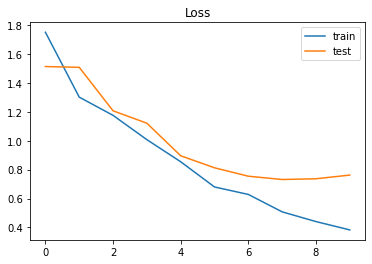

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

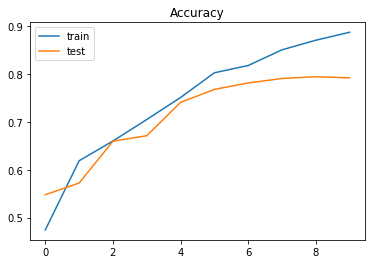

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [43]:
# model.save(f"drive/MyDrive/Colab Notebooks/classifier_model.h5")
# with open('drive/MyDrive/Colab Notebooks/classifier_tokenizer.pkl', 'wb') as classifier_tokenizer:
  # pickle.dump(tokenizer, classifier_tokenizer)

with open('drive/MyDrive/Colab Notebooks/classifier_tokenizer.pkl', 'rb') as classifier_tokenizer: 
  tokenizer = pickle.load(classifier_tokenizer)
 
model = keras.models.load_model("drive/MyDrive/Colab Notebooks/classifier_model.h5")


In [28]:
with open('hamshahriold/ham2/Categories.txt',"r", encoding="utf8") as content:
    content = content.read()

lines = content.split("\n")
cat_dict = {}
sub_cat = {}
for line in lines:
    if line:
        splited = line.split("\t")
        cat_dict[splited[0]] = (splited[1], splited[2])
        if splited[1] in sub_cat:
            sub_cat[splited[1]].append(splited[0])
        else:
            sub_cat[splited[1]] = [splited[0]]

# cat_dict
print(cat_dict)
s = dict(sorted(sub_cat.items()))

# for key, val in s.items():
#     print(key, len(val))

{'adabh': ('Literature and Art', 'ادب و هنر'), 'ejtem': ('Social', 'اجتماعی'), 'elmfa': ('Science and Culture', 'علمی فرهنگی'), 'eqtes': ('Economy', 'اقتصاد'), 'gozar': ('Miscellaneous', 'گوناگون'), 'havad': ('Miscellaneous.Happenings', 'گوناگون.حوادث'), 'kharj': ('Miscellaneous.World News', 'گوناگون.خارجی'), 'maqal': ('Miscellaneous', 'گوناگون'), 'shahr': ('Miscellaneous.Urban', 'گوناگون.شهری'), 'siasi': ('Politics', 'سیاسی'), 'varze': ('Sport', 'ورزش'), 'gungn': ('Miscellaneous', 'گوناگون'), 'axrooz': ('Miscellaneous.Picture', 'گوناگون.عکس'), 'cartoon': ('Miscellaneous.Picture.Caricature', 'گوناگون.عکس.کاریکاتور'), 'shahrstn': ('Miscellaneous', 'گوناگون'), 'nameh': ('Miscellaneous', 'گوناگون'), 'mohitz': ('Natural Environment', 'محیط زیست'), 'telfn': ('Miscellaneous', 'گوناگون'), 'mohit': ('Natural Environment', 'محیط زیست'), 'gofgu': ('Miscellaneous', 'گوناگون'), 'elmif': ('Science and Culture', 'علمی فرهنگی'), 'gqarn': ('Miscellaneous', 'گوناگون'), 'shari': ('Miscellaneous.Urban', 

In [48]:
def predict_cat(text:str):
  text = text_normalization(text)
  tokens = tokenize_text(text)
  cats = df['category'].drop_duplicates().values.tolist()
  seq = tokenizer.texts_to_sequences([tokens])

  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = model.predict(padded)
  print("Your news category:", cat_dict[cats[np.argmax(pred)]])

news = input("Please enter your news text: ")
predict_cat(news)

Please enter your news text: میرهاشم موسوی در پاسخ به گلایه‌ها و انتقادات بازنشستگان غیرحداقلی‌بگیر از نحوه افزایش حقوق‌ها در سال جاری اظهار کرد: آنچه ما باید بر اساس قانون به عنوان سازمان تامین اجتماعی انجام می‌دادیم همان را انجام دادیم و همان مسیری بوده که تا کنون طی کرده‌ایم.  وی افزود: در ماده ۹۶ قانون تامین اجتماعی قید شده است که میزان افزایش حقوق غیرحداقلی‌بگیران باید بر اساس هزینه‌های زندگی تعیین و سپس در هیئت وزیران مصوب شود و به اجرا دربیاید. در ماده ۱۱۱ قانون تامین اجتماعی هم آمده است که میزان افزایش حقوق حداقلی‌بگیران نباید از حداقل دستمزد کارگران که در شورای عالی کار مصوب شده، کمتر باشد.  مدیرعامل سازمان تامین اجتماعی با بیان اینکه ما بر اساس ماده ۹۶ و ۱۱۱ قانون تامین اجتماعی مسیر افزایش حقوق‌ها را طی کرده و مصوبه هیئت امنای تامین اجتماعی را به دولت ارسال کردیم گفت: این تصمیم، تصمیمِ بخشی و سازمانی ما بود و هیئت امنا همین را پذیرفت و به هیئت دولت ارسال کرد اما اقتضائاتی که در هیئت دولت مطرح است، به علاوه نگاه بخشی ما در تامین اجتماعی است و طبیعتا قانونگذار هم این اختیار را 

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df

,category,category_id,tokens
0,adabh,0,"[جاودانگی, زندگی, گروهی, طریق, هنر, نگاه, نمایشگاه, آثار, هنر, احمد, طباطبایی, موضوع, آثار, طباطبایی, مورچگان, باطن, ظاهر, انسانهاهستند, هیبت, حشره, تابلو, نقاش, نمایشگر, گوشه, زندگی, مورچه, دید#بین, سنگین, خودرا, دوش, کشید#کش, راه, خسته, شد#شو, نتیجه, آمدن, حادثه, اتفاق, دست, رها, گریز, خطر, گذاشت#گذار, فرار, کرد#کن, ساعت, نقطه, برمی, گشت#گرد, دوش, کشیده, نفس, زن, عرق, ریز, منزل, رساند#رسان, دانست#دان, راه, رفت#رو, مورچه, استعداد, غریزه, عملی, شروع, پایان, رساند#رسان, دانست#دان, نسل, آینده, مزایا, استفاده, نمود#نما, داستان, دراز, انتها, پایان, میلیون, سال, گذشته, میلیارد, سال, گذشت#گذر, وهمین, برنامه, میلیون, تجدید, شد#شو, گفت#گو, سیر, حیات, تکامل, پایان, ناپذیر, اسرار, جهان, پایان, خواست#خواه, چیز, پایان, ...]"
1,adabh,0,"[رویداد, هنر, جهان, نمایشگاه, هنر, خدمت, دیکتاتورها, نمایشگاه, ارتباط, هنر, وقدرت, دیکتاتورها, اروپا, درشهر, برلین, آغاز, کار, کرد#کن, گزارش, واحد, مرکزی, خبر, نقل, شبکه, خبر, اروپا, نمایشگاه, موزه, تاریخ, آلمان, برپا, شد#شو, ترتیبدهندگان, نمایش, گذاشتن, آثار, نقاش, مجسمه, سازی, قصد, داشت#دار, نشان, داد#ده, آثار, هنر, سال, عنوان, وسائل, تبلیغاتی, استفاده, شد#شو, نمایشگاه, سوءاستفاده, هنر, هیتلر, زمان, آلمان, نازی, موسیلینی, ایتالیا, سردمدار, اتحاد, جماهیر, شوروی, اسپانیا, دیکتاتورهای, بزرگ, اوائل, قرن, حاضر, اروپا, نمایش, گذاشت#گذار, نمایشگاه, اثر, هنر, معرض, نمایش, گذاشته, شد#شو, نمایشگاه, آثار, پیکاسو, اردن, ملکه, اسپانیا, سوفیا, همراه, ملکه, اردن, نور, نمایشگاه, آثار, پیکاسو, رادر, گالری, ملی, اردن, افتتاح, کرد#کن, ...]"
2,adabh,0,"[بردیوار, نگارخانه, گالری, گلستان, نمایشگاه, طرح, ساخت, نقره, وسنگ, ثریا, امانپور, تیرماه, تااز, ساعت, خیابان, دروس, شهیدکماسایی, شماره, تلفن, نگارخانه, آفرینش, سرو, نمایشگاه, آثار, عکاس, شهریار, توکل, فرشید, آذررنگ, تیرماه, ساعت, عصر, کوچه, ساعی, فرهنگسرا, سرو, نگارخانه, آفرینش, امیرکبیر, نمایشگاه, نقاش, مرجان, خسرونژادتا, تیرماه, ساعت, پارک, قیطریه, فرهنگسرا, امیرکبیر, تلفن, نگارخانه, هنر, ایران, نمایشگاه, نقاش, محمدکاظم, ویزواری, سوم, نهم, تیرماه, ساعت, کارگر, شمال, روبرو, پارک, لاله, کوی, شهید, صدوق, شماره, تلفن, لا, گالری, هفت, ثمر, نمایشگاه, نقاشی‌های, فاطمه, وفا, نژاد, روز, تیرماه, ازساعت, خیابان, کوه, مطهر, نور, کوی, پنجم, شماره, تلفن, نگارخانه, تهران, نمایشگاه, آثار, نقاش, اساتیدمرحوم, فتح, الله, عبادی, ...]"
3,ejtem,1,"[بازی, جدی, گرفت#گیر, مطالعه, مقدمات, نقش, بازی, زندگی, اجتماع, ساماندهی, گردشگاه, حرکت, شلوغ, کردن, جلوه, ازلذت, کودکانه, سرکوبومخالفت, جنب, وجوش, کودک, آسیب, روان, آورد#آور, زمین, بازی, فعالیت, هنرمندانه, سازنده, بازی, پرتحرک, تشویق, ترویج, اشاره, چگونگی, ساماندهی, گذر, اوقات, فراغت, تامین, فضا, فراغت, شهر, بزرگ, روزبروز, اهمیت, برنامه, ریخت#ریز, طراح, شهر, پیدا, کرد#کن, موضوع, ابعاد, مختلف, اجتماع, فرهنگ, کالبد, فن, مدیریت, روبرو, روند, برنامه, ریخت#ریز, دشوار, ساخت#ساز, نظر, آشنایی, تجاربجهانی, وسایل, توانست#توان, زمینه, راهگشا, بود#باش, مطلب, آمد#آ, برگرفته, کتابزمین‌های, بازی, وفضاهای, تفریح, تالیف, آلفردلدرمان, وتراچل, مهندسین, مشاور, زادبوم, ترجمه, شد#شو, انسان, زمان, بازی, کرد#کن, مفهوم, کامل, کلمه, انسان, بود#باش, زمان, انسان, ...]"
4,elmfa,2,"[تخته, سیاه, غبار, سترده, شد#شو, اشاره;, رغم, گسترش, توسعه, روزافزون, تکنولوژی, آموزش, استفاده, وسیع, افزار, نرم, افزار, کمک, تحصیل, فرآیند, یادگیری, دانش, آموزان, کشور, توسعه, یافته, نقش, تخته, سیاه, سایر, تخته, آموزش, قابل, تامل, بوده, اثربخشی, استفاده, ابزار, امر, آموزش, مفاهیم, کودک, پژوهش, مختلف, تربیت, اثبات, رسید#رس, آستانه, شروع, تعطیلات, تابستان, فرصت, دو, ماه, نیمه, بازگشایی, مدارس, باقی, نتایج, حاصل, پژوهش, دانشگاه, تخته, سیاه, تخته, آموزش, آورد#آور, امید, مدیر, محترم, مدارس, دست, اندرکاران, امور, آموزش, برنامه, تجهیز, بهسازی, فضا, آموزش, تابستان, نیم, نگاه, تخته, سیاه, مدارس, مه, بخش, رسانه, یادگیری, داشت#دار, نقش, آموزش, پرورش, توسعه, فرهنگ, اقتصاد, اجتماع, پوشیده, نیست, ...]"
...,...,...,...
165220,vrzsh,10,"[نماینده, فدراسیون, جهانی, والیبال, ایران, نظر, شایسته, میزبان, مسابقات, جوان, جهان, گروه, ورزش, نماینده, فدراسیون, المللی, والیبال, بازدید, امکانات, ورزش, کشور, برگزاری, مسابقات, جوان, جهان, تهران, سفر, کرد#کن, قبل, پرواز, لوزان, سوئیس, ارائه, گ